In [ ]:
from google. colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [ ]:
train_path = '/content/drive/MyDrive/resized/train'
valid_path = '/content/drive/MyDrive/resized/val'
test_path = '/content/drive/MyDrive/resized/test'
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224),
classes=['No_DR','Mild','Moderate','Severe','Proliferate_DR'], shuffle = True)
valid_batches= ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, target_size=(224,224),
classes=['No_DR','Mild','Moderate','Severe','Proliferate_DR'], shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224),
classes=['No_DR','Mild','Moderate','Severe','Proliferate_DR'], shuffle = False)

Found 2536 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3, 3), padding="valid", input_shape=(224, 224, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3, 3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4, 4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_batches, epochs=100, validation_data=valid_batches)

Epoch 1/100
80/80 [==============================] - 1009s 13s/step - loss: 1.1664 - accuracy: 0.5627 - val_loss: 1.4931 - val_accuracy: 0.5073
Epoch 2/100
80/80 [==============================] - 99s 1s/step - loss: 0.8750 - accuracy: 0.6893 - val_loss: 1.3573 - val_accuracy: 0.6545
Epoch 3/100
80/80 [==============================] - 99s 1s/step - loss: 0.8065 - accuracy: 0.7082 - val_loss: 1.2683 - val_accuracy: 0.4982
Epoch 4/100
80/80 [==============================] - 101s 1s/step - loss: 0.7807 - accuracy: 0.7165 - val_loss: 1.1210 - val_accuracy: 0.6618
Epoch 5/100
80/80 [==============================] - 103s 1s/step - loss: 0.7364 - accuracy: 0.7315 - val_loss: 0.9625 - val_accuracy: 0.6927
Epoch 6/100
80/80 [==============================] - 101s 1s/step - loss: 0.7179 - accuracy: 0.7409 - val_loss: 0.8548 - val_accuracy: 0.7182
Epoch 7/100
80/80 [==============================] - 101s 1s/step - loss: 0.6965 - accuracy: 0.7484 - val_loss: 0.7765 - val_accuracy: 0.7327
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/blindness-detection/e5model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-7-b08fd55361be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 13s 744ms/step - loss: 0.7934 - accuracy: 0.7709
Loss:  0.7934137582778931
Accuracy:  0.7709090709686279


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Assuming you have your test_batches prepared as mentioned in the previous code snippet

# Get the predictions for the test set
test_predictions = model.predict(test_batches)

# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Convert true labels to class labels
true_labels = test_batches.classes

# Get the class names
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Calculate overall test accuracy
test_accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f"Overall Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate accuracy for each class
class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_idx = test_batches.class_indices[class_name]
    class_true_labels = (true_labels == class_idx)
    class_predicted_labels = (predicted_labels == class_idx)
    class_acc = np.sum(class_true_labels & class_predicted_labels) / np.sum(class_true_labels)
    class_accuracy[class_name] = class_acc
    print(f"Accuracy for {class_name}: {class_acc * 100:.2f}%")


18/18 [==============================] - 8s 415ms/step
Classification Report:
                precision    recall  f1-score   support

         No_DR       0.94      0.97      0.95       271
          Mild       0.56      0.52      0.54        56
      Moderate       0.65      0.77      0.71       150
        Severe       0.36      0.14      0.20        29
Proliferate_DR       0.44      0.27      0.34        44

      accuracy                           0.77       550
     macro avg       0.59      0.53      0.55       550
  weighted avg       0.75      0.77      0.75       550

Confusion Matrix:
[[263   1   7   0   0]
 [  7  29  15   0   5]
 [  9  16 116   2   7]
 [  0   1  21   4   3]
 [  2   5  20   5  12]]
Overall Test Accuracy: 77.09%
Accuracy for No_DR: 97.05%
Accuracy for Mild: 51.79%
Accuracy for Moderate: 77.33%
Accuracy for Severe: 13.79%
Accuracy for Proliferate_DR: 27.27%


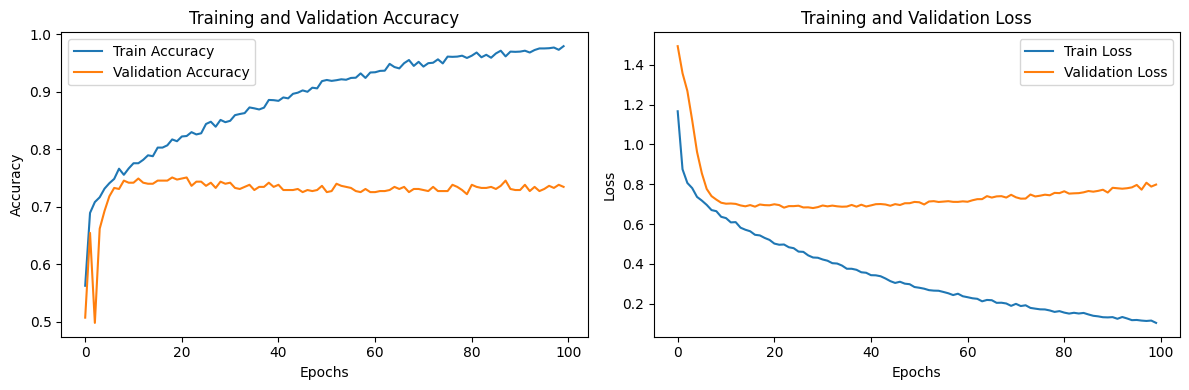

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = keras.models.load_model('/content/drive/MyDrive/blindness-detection/emodel.h5')  # Replace 'your_model_path.h5' with the actual path to your model file

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of your model
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to get the predicted class name for an image
def predict_image(image_path, class_labels):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Get class labels as a list from the test generator
class_labels = list(test_batches.class_indices.keys())

# Example usage
test_image_path = '/content/drive/MyDrive/resized/test/Proliferate_DR/0e0fc1d9810c.png'  # Replace 'path_to_your_test_image.jpg' with the actual path to your test image
predicted_class = predict_image(test_image_path, class_labels)
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 136ms/step
Predicted class: Proliferate_DR


In [ ]:
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = keras.models.load_model('/content/drive/MyDrive/blindness-detection/emodel.h5')  # Replace 'your_model_path.h5' with the actual path to your model file

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of your model
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to get the predicted class name for an image
def predict_image(image_path, class_labels):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Get class labels as a list from the test generator
class_labels = list(test_batches.class_indices.keys())

# Example usage
test_image_path = '/content/drive/MyDrive/resized/test/No_DR/005b95c28852.png'  # Replace 'path_to_your_test_image.jpg' with the actual path to your test image
predicted_class = predict_image(test_image_path, class_labels)
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 122ms/step
Predicted class: No_DR


In [ ]:
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = keras.models.load_model('/content/drive/MyDrive/blindness-detection/emodel.h5')  # Replace 'your_model_path.h5' with the actual path to your model file

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of your model
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to get the predicted class name for an image
def predict_image(image_path, class_labels):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Get class labels as a list from the test generator
class_labels = list(test_batches.class_indices.keys())

# Example usage
test_image_path = '/content/drive/MyDrive/resized/test/Moderate/3a61e690f4bb.png'  # Replace 'path_to_your_test_image.jpg' with the actual path to your test image
predicted_class = predict_image(test_image_path, class_labels)
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 141ms/step
Predicted class: Moderate


In [ ]:
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = keras.models.load_model('/content/drive/MyDrive/blindness-detection/emodel.h5')  # Replace 'your_model_path.h5' with the actual path to your model file

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of your model
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to get the predicted class name for an image
def predict_image(image_path, class_labels):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Get class labels as a list from the test generator
class_labels = list(test_batches.class_indices.keys())

# Example usage
test_image_path = '/content/drive/MyDrive/resized/test/Mild/4dd5d5ccddcf.png'  # Replace 'path_to_your_test_image.jpg' with the actual path to your test image
predicted_class = predict_image(test_image_path, class_labels)
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 189ms/step
Predicted class: Mild


In [ ]:
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = keras.models.load_model('/content/drive/MyDrive/blindness-detection/emodel.h5')  # Replace 'your_model_path.h5' with the actual path to your model file

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of your model
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to get the predicted class name for an image
def predict_image(image_path, class_labels):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Get class labels as a list from the test generator
class_labels = list(test_batches.class_indices.keys())

# Example usage
test_image_path = '/content/drive/MyDrive/resized/test/Severe/90b8bf342032.png'  # Replace 'path_to_your_test_image.jpg' with the actual path to your test image
predicted_class = predict_image(test_image_path, class_labels)
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 126ms/step
Predicted class: Severe
